# Bengali.AI Handwritten Grapheme Classification
This is a contest for optical character recognition for the written Bengali language spoken by about 200 million people. Most of these people live in Bangladesh and India. Bengali consists of 49 letters (11 vowels, 38 consonants) which can have 18 accents. This multiplies to about 13 000 possible letters to be identified by a model.

![Header image](https://upload.wikimedia.org/wikipedia/commons/0/05/%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE_%E0%A6%95%E0%A6%BE%E0%A6%B0%E0%A6%B8%E0%A6%AE%E0%A7%82%E0%A6%B9.svg)
<a href="https://commons.wikimedia.org/wiki/File:%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE_%E0%A6%95%E0%A6%BE%E0%A6%B0%E0%A6%B8%E0%A6%AE%E0%A7%82%E0%A6%B9.svg" title="via Wikimedia Commons">Nirvik12</a> [<a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA</a>]

## Goal
This is why the recognition challenge is split up into three smaller challenges:
1. Identify the base letter (*grapheme root*)
2. Identify the accent of the vowel (*vowel diacritic*) or
3. Identify the accent of the consonant (*consonant diacritic*)

## Files
* `class_map.csv`: 3 columns
    * `Component_type` which are either the base letter or consonant accent or vowel accent
    * `Label` the component label
    * `Component` visual representation of the component
* `train.csv`: contains meta information about the actual pictures
    * `Image_Id` the key for the pictures contained in the `.parquet` files
    * `Grapheme_root` the label of the base letter of this character
    * `Vowel_diacritic` the label of the vowel accent
    * `Consonant_diacritic` the label of the consonant diacritic
    * `Graphme` the complete letter for illustration purposes
    * **verify**: label 0 means that there is no accent because, for example, a vowel base letter cannot have a consonant accent. This means a classification into vowel and consonant beforehand might be useful
* `test.csv`: every image will require three predictions
    * `Row_Id` key to the sample submission
    * `Image_Id` key to the `.parquet` file
    * `Component` the component to be predicted
* `sample_submission.csv`: the example
    * `Row_Id` the submission key concatenated with the required diacritic
    * `Target` the predicted label for the target type
* `.parquet` files: contain the actual pixel data
    * Four files for each train and test data
    * *Going to find out more now...*

## Data `.parquet` files

In [37]:
# Python libraries
import os
# External libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Self-written

In [38]:
data_path = os.path.join('..', 'data', 'bengaliai-cv19')
data_files = os.listdir(data_path)
train_files = [f for f in data_files if 'parquet' in f and 'train' in f]
test_files = [f for f in data_files if 'parquet' in f and 'test' in f]
print(train_files)
print(test_files)

['train_image_data_0.parquet', 'train_image_data_1.parquet', 'train_image_data_2.parquet', 'train_image_data_3.parquet']
['test_image_data_0.parquet', 'test_image_data_1.parquet', 'test_image_data_2.parquet', 'test_image_data_3.parquet']


In [39]:
print('Training data files:')
for file in train_files:
    train_data = pd.read_parquet(os.path.join(data_path, file))
    print('Shape:', train_data.shape)
    print(train_data.head(3))
    del train_data
    
print('Test data files:')
for file in test_files:
    test_data = pd.read_parquet(os.path.join(data_path, file))
    print('Shape:', test_data.shape)
    print(test_data.head(3))
    del test_data

Training data files:
Shape: (50210, 32333)
  image_id    0    1    2    3    4    5    6    7    8  ...  32322  32323  \
0  Train_0  254  253  252  253  251  252  253  251  251  ...    253    253   
1  Train_1  251  244  238  245  248  246  246  247  251  ...    255    255   
2  Train_2  251  250  249  250  249  245  247  252  252  ...    254    253   

   32324  32325  32326  32327  32328  32329  32330  32331  
0    253    253    253    253    253    253    253    251  
1    255    255    255    255    255    255    255    254  
2    252    252    253    253    253    253    251    249  

[3 rows x 32333 columns]
Shape: (50210, 32333)
      image_id    0    1    2    3    4    5    6    7    8  ...  32322  \
0  Train_50210  246  253  251  250  249  252  246  250  250  ...    255   
1  Train_50211  250  245  241  244  249  253  253  254  254  ...    254   
2  Train_50212  248  248  249  249  250  251  250  250  249  ...    255   

   32323  32324  32325  32326  32327  32328  32329  323

* Rows represent images, all the columns but the first are pixel values
    * First column: The ID of the image such that it can be found in the `train.csv`
* Pixel values range from 0 to 255
* In both train and test sets, there are 32332 values, which represent the 137 $*$ 236 pixels of each picture, whether row by row or column by column will be found out by reconstructing a few images
* Each training batch contains 50210 images, they are continously numbered throughout the four files
    * We have 200840 training images
* Each test batch contains three images
    * We have 12 test images, for each we have to make predictions for all three targets, meaning we have to make 36 predictions

In [40]:
from random import random

rand_index = lambda data_frame: round(random() * len(data_frame))

first_batch = pd.read_parquet(os.path.join(data_path, train_files[0]))
random_index_0 = rand_index(first_batch)
random_index_1 = rand_index(first_batch)
random_index_2 = rand_index(first_batch)

In [41]:
box_shape = (137, 236) # As described in the competition description

ex_0 = first_batch.iloc[random_index_0][1:].to_numpy(dtype = float) / 255
ex_1 = first_batch.iloc[random_index_1][1:].to_numpy(dtype = float) / 255
ex_2 = first_batch.iloc[random_index_2][1:].to_numpy(dtype = float) / 255
ex_0 = ex_0.reshape(box_shape)
ex_1 = ex_1.reshape(box_shape)
ex_2 = ex_2.reshape(box_shape)

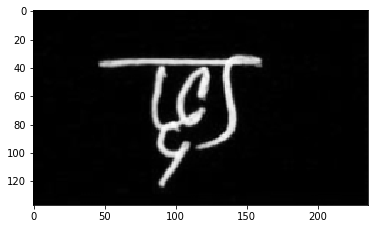

In [42]:
%matplotlib inline
plt.imshow(ex_0, cmap = 'Greys')

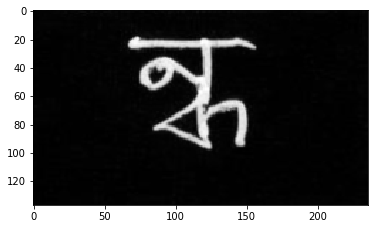

In [43]:
plt.imshow(ex_1, cmap = 'Greys')

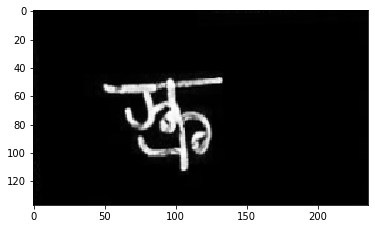

In [44]:
plt.imshow(ex_2, cmap = 'Greys')